# Importing and Processing Data

First, we'll import the data and give the columns shorter mnemonic names that are more practical to refer to in source code.  Then we'll prepare the data for statistical analysis by coercing data into the correct types (i.e., numbers and categories from text).

In [82]:
import numpy as np
import pandas as pd
import collections # for defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

as_imported = pd.read_csv("2019.csv")
data = pd.read_csv("2019.csv")
descriptions = data.columns
data.columns = [
    'consent_1', # important for data consent, irrelevant for analysis
    'extra', # Too sparse for stats
    'consent_2', # important for data consent, irrelevant for analysis
    'job_title', # Too sparse for stats
    'job_role', # Too sparse for stats
    'benefits_salary', 
    'benefits_salary_year',
    'benefits_paid_vac_days', # many erroneous values (365)
    'benefits_bonus', 
    'job_reports',
    'job_type',
    'employer_dept', # Too sparse for stats
    'employer_ownership',  # Shortened names
    'employer_fte', # Too few data points per category; not 
    'loc', # Not enough diversity for stats
    'experience', # good spread
    'job_remote', # binary
    'employer_loc', # Not enough data for anything but ROC/Other
    'benefits_other', # Too sparse for stats
    'gender',
    'education',
    'identity', # multiple y/n variables requires further parsing, data sparse except for parents
    'race',
    'universities',  # Too sparse for useful stats
    'job_description',  # Too sparse for useful stats
    'job_tenure', 
    'outside_income']
as_imported.columns = data.columns

data["benefits_salary"] = data["benefits_salary"].replace('[\$,]', '', regex=True).astype(float)
data["benefits_bonus"] = data["benefits_bonus"].replace('[\$,]', '', regex=True).astype(float)
bonus = data["benefits_bonus"].to_numpy()
bonus_nas = np.isnan(data["benefits_bonus"])
bonus[bonus_nas] = 0
data["job_income"] = data["benefits_salary"].to_numpy() + bonus
data["job_income"] = data["job_income"] / 1000
data["outside_income"] = data["outside_income"].replace('[\$,]', '', regex=True).astype(float)
data["job_reports"] = data["job_reports"].astype('category')
data["job_type"] = data["job_type"].astype('category')
data["employer_ownership"] = data["employer_ownership"].map({
    "Private - Founder still holds majority": "Founder",
    "Private - Other/Unknown": "Investors",
    "Public": "Markets",
    "Government": "Government",
}).astype('category')
data["employer_fte"] = data["employer_fte"].map({
    "2-10": "<200",
    "11-50": "<200",
    "51-200": "<200",
    "201-500": ">200",
    "501-1000": ">200",
    "1001-2000": ">200",
    "2001-5000": ">200",
    "5001-10,000": ">200",
    "10,000+": ">200",
}).astype('category')
data['experience'] = data['experience'].astype('category');
data['job_remote'] = data['job_remote'].astype('category');
loc_map = collections.defaultdict(lambda: "Other")
loc_map.update({
    "Rochester": "Rochester",
    "Rochester, NY": "Rochester",
})
data["employer_loc"].map(loc_map)
data['gender'] = data['gender'].astype('category')
data['education'] = data['education'].astype('category')
data['race'] = data['race'].astype('category')

In [83]:
# Total Income

# About the Respondents

Who responded to the survey?

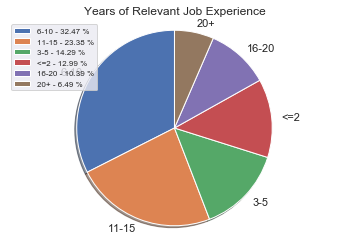

<Figure size 1200x1200 with 0 Axes>

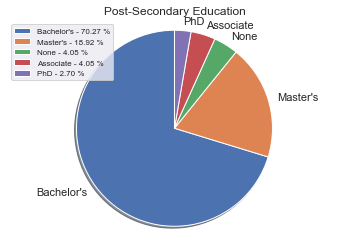

<Figure size 1200x1200 with 0 Axes>

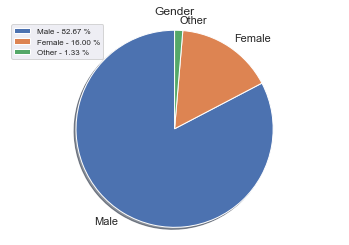

<Figure size 1200x1200 with 0 Axes>

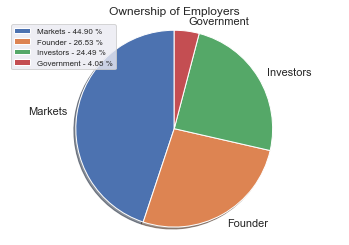

<Figure size 1200x1200 with 0 Axes>

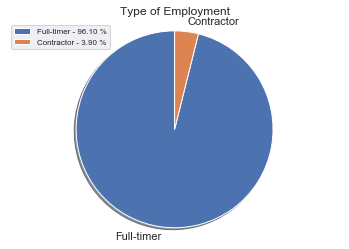

<Figure size 1200x1200 with 0 Axes>

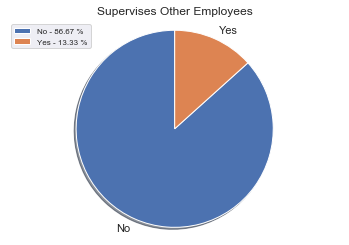

<Figure size 1200x1200 with 0 Axes>

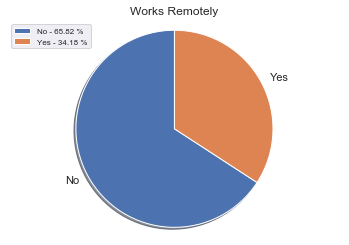

<Figure size 1200x1200 with 0 Axes>

In [84]:
def mmpie(data,col_name,title):
    cats = data[col_name].value_counts().to_dict()
    x = list(cats.keys())
    y = data[col_name].value_counts().to_numpy()
    percent = 100.0 * y / y.sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]
    fig1, ax1 = plt.subplots()
    plt.figure(figsize=(6,6), dpi=200)
    patches, texts = ax1.pie(y, 
        # explode=explode, 
        labels=x, 
        # autopct='%1.1f%%',
        shadow=True, 
        startangle=90, 
        # pctdistance=0, 
        # labeldistance=1.05
            )
    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                      key=lambda x: x[2],
                                      reverse=True))
    ax1.legend(patches, labels, 
               loc='upper left', 
               # bbox_to_anchor=(-0.1, 1.),
               fontsize=8
               )

    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    ax1.set(title=title)
        
    fig1.savefig("figures/" + col_name + ".svg")
    plt.show()

mmpie(data,'experience', "Years of Relevant Job Experience")
mmpie(data,'education', "Post-Secondary Education")
mmpie(data,'gender', "Gender")
mmpie(data,'employer_ownership', "Ownership of Employers")
mmpie(data,'job_type', "Type of Employment")
mmpie(data,'job_reports', "Supervises Other Employees")
mmpie(data,'job_remote', "Works Remotely")


The first thing we're interested in is the overall salary curve itself.

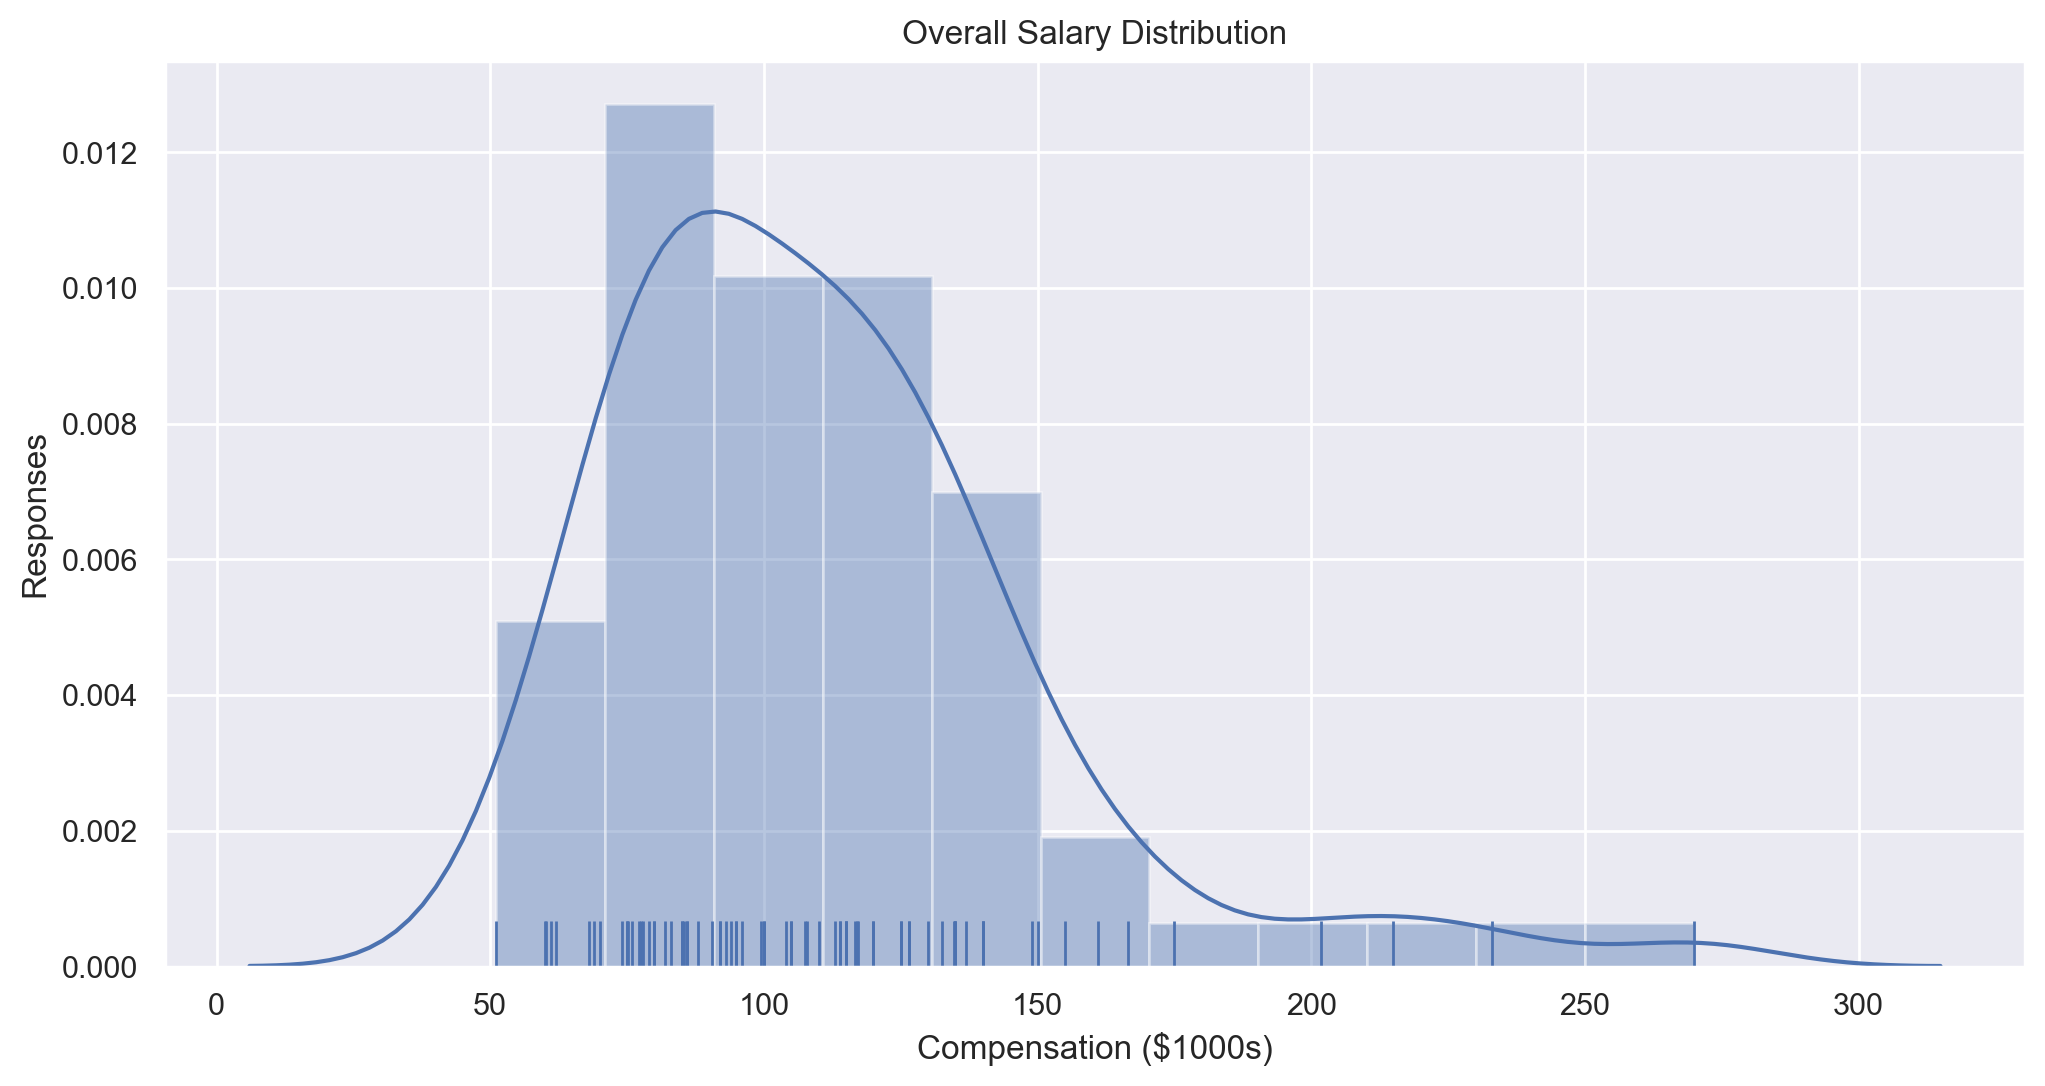

In [85]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.distplot(data['job_income'].dropna(),
                    rug=True, 
                   # kde=False
                   )
plot.set(
    xlabel="Compensation ($1000s)",
    ylabel="Responses",
    title="Overall Salary Distribution"
)
plot.get_figure().savefig("figures/compensation.svg")
plt.show()

Then breaking it down by a number of interesting categories.

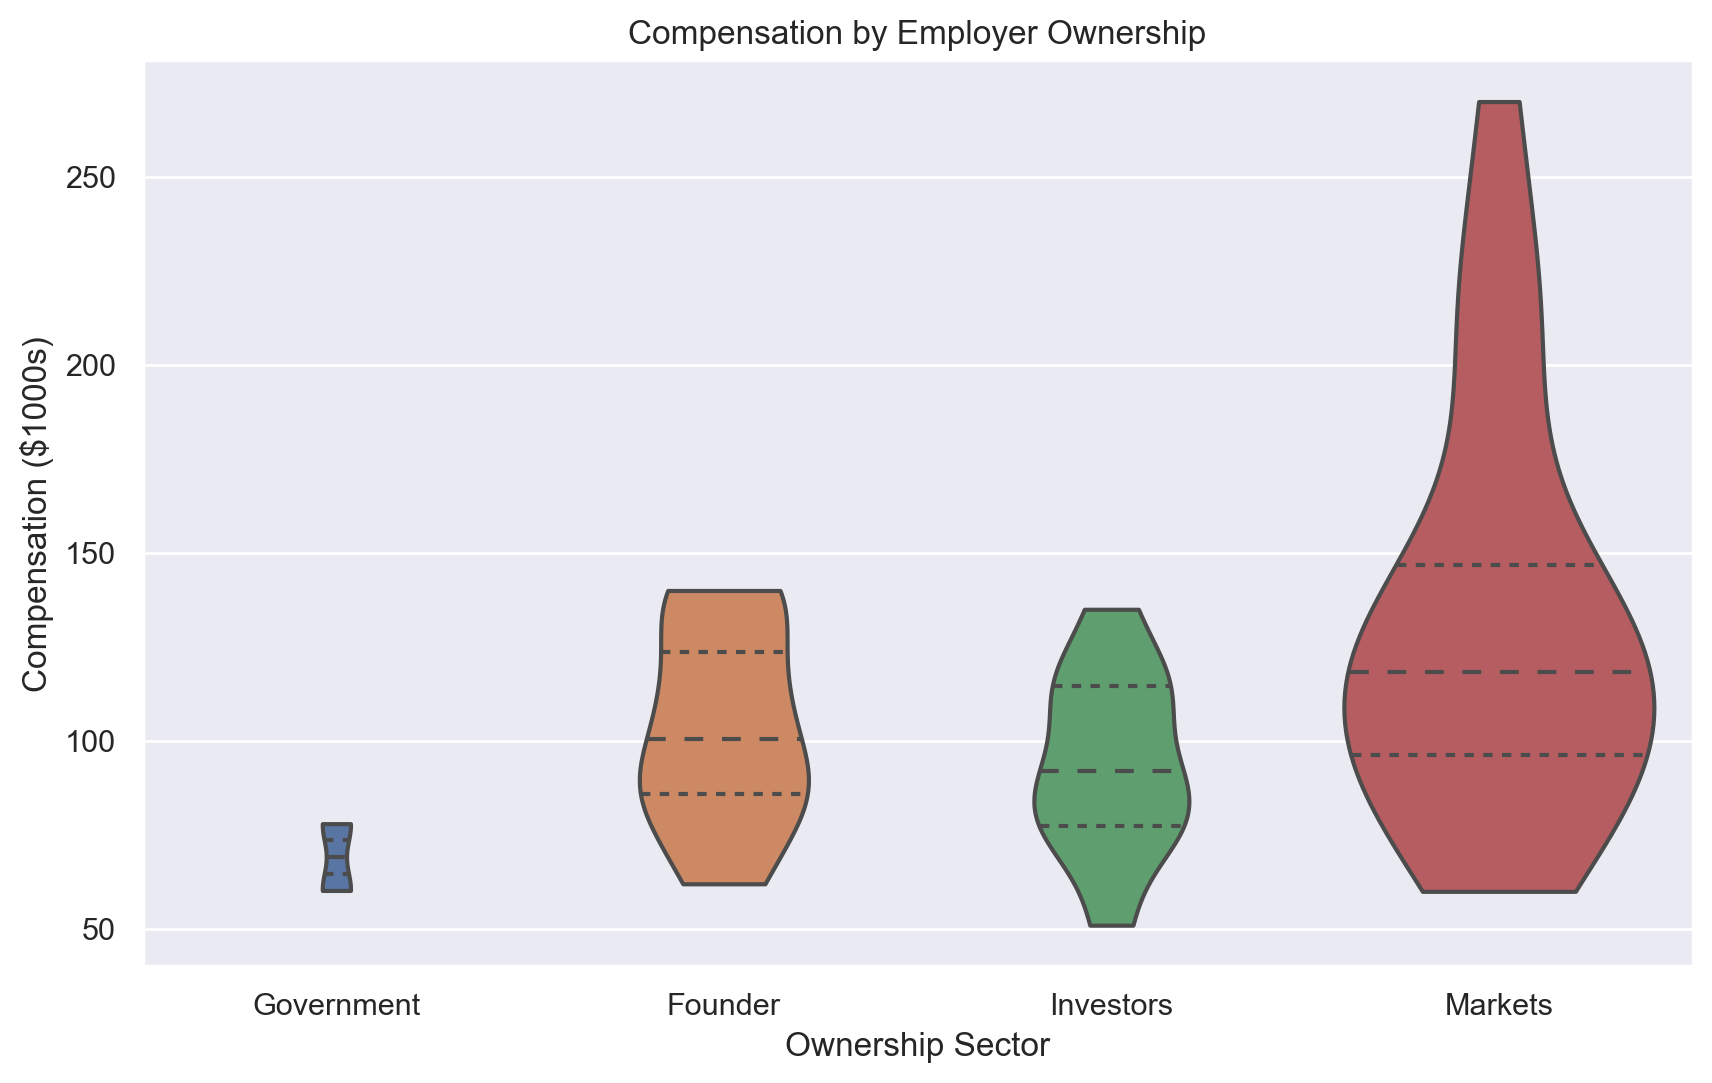

In [86]:
plt.figure(figsize=(10,6), dpi=200)
plot = sns.violinplot(
    x = "employer_ownership",
    y = "job_income",
    order = ["Government", "Founder", "Investors", "Markets"],
    scale = "count", inner="quartile", bw=0.5, cut=0,
    data=data,
)
plot.set(
    xlabel="Ownership Sector",
    ylabel="Compensation ($1000s)",
    title="Compensation by Employer Ownership"
)
plot.get_figure().savefig("figures/by_ownership.svg")

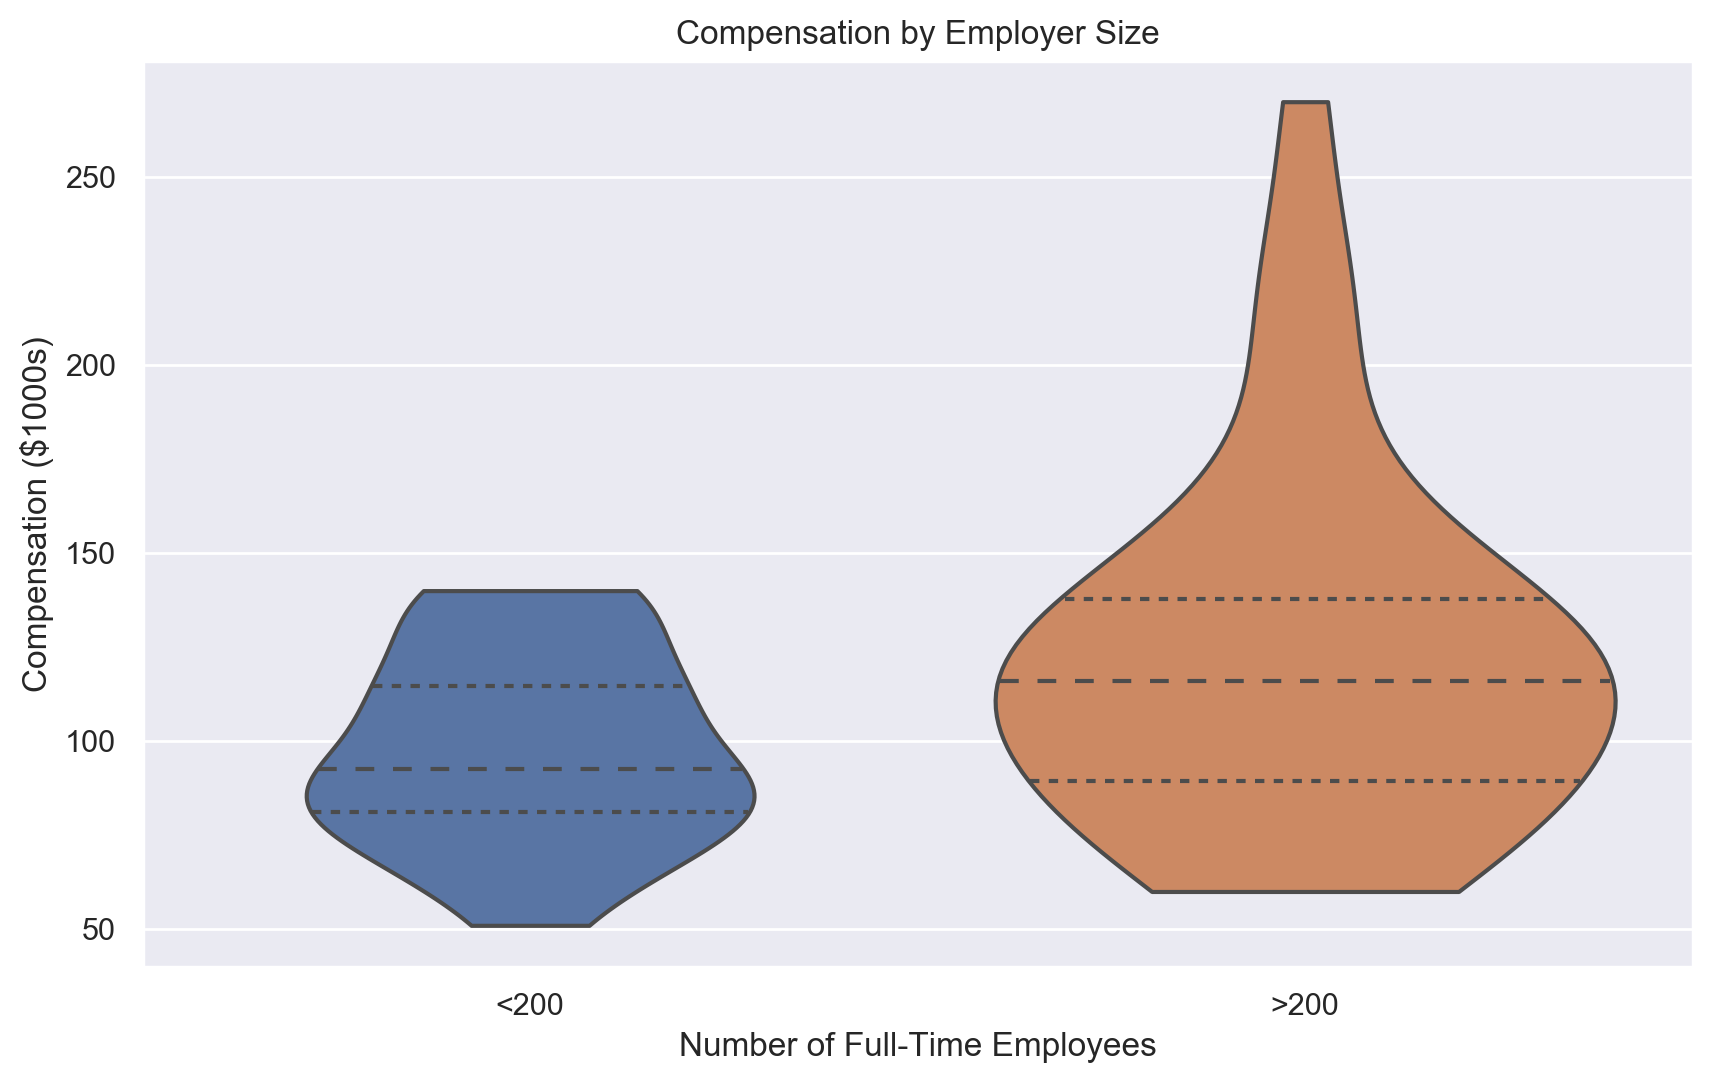

In [87]:
plt.figure(figsize=(10,6), dpi=200)
plot = sns.violinplot(
     x = "employer_fte",
     y = "job_income",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    data=data,
)
plot.set(
    xlabel="Number of Full-Time Employees",
    ylabel="Compensation ($1000s)",
    title="Compensation by Employer Size"
)
plot.get_figure().savefig("figures/by_size.svg")

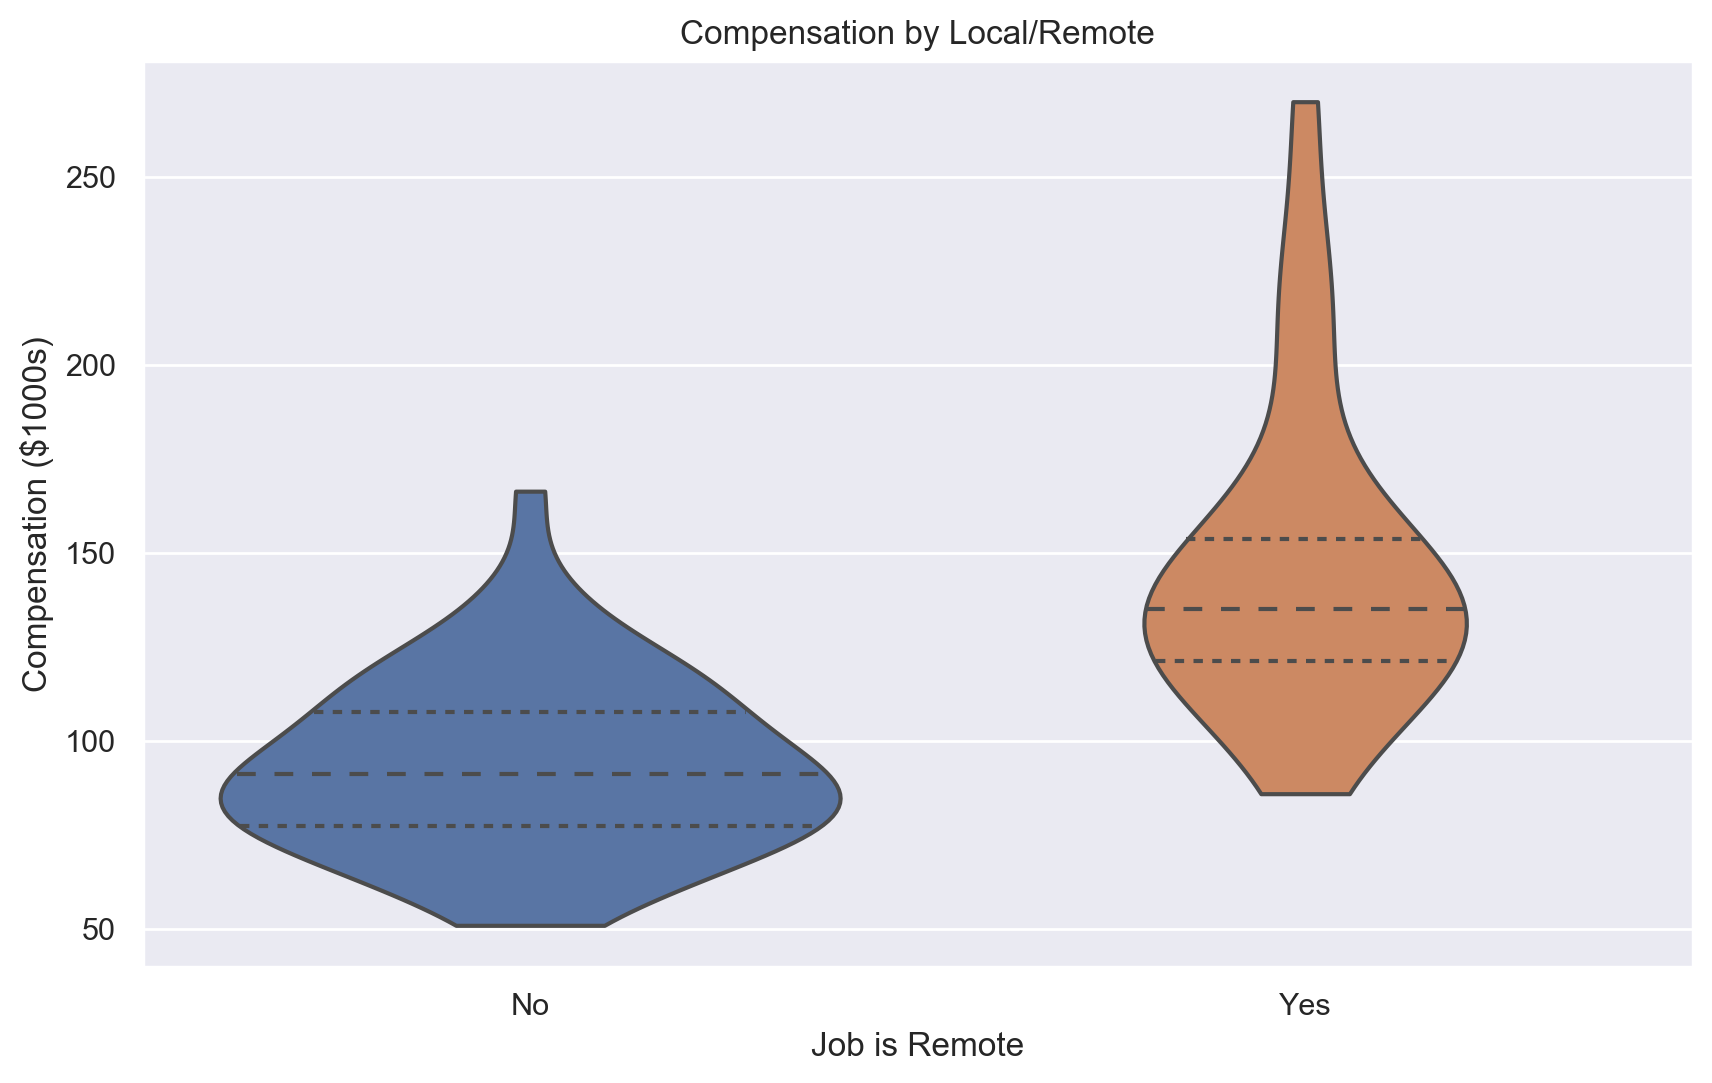

In [88]:
plt.figure(figsize=(10,6), dpi=200)
plot = sns.violinplot(
    x = "job_remote",
    y = "job_income",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    data=data,
)
plot.set(
    xlabel="Job is Remote",
    ylabel="Compensation ($1000s)",
    title="Compensation by Local/Remote"
)
plot.get_figure().savefig("figures/by_remote.svg")

<Figure size 2000x1200 with 0 Axes>

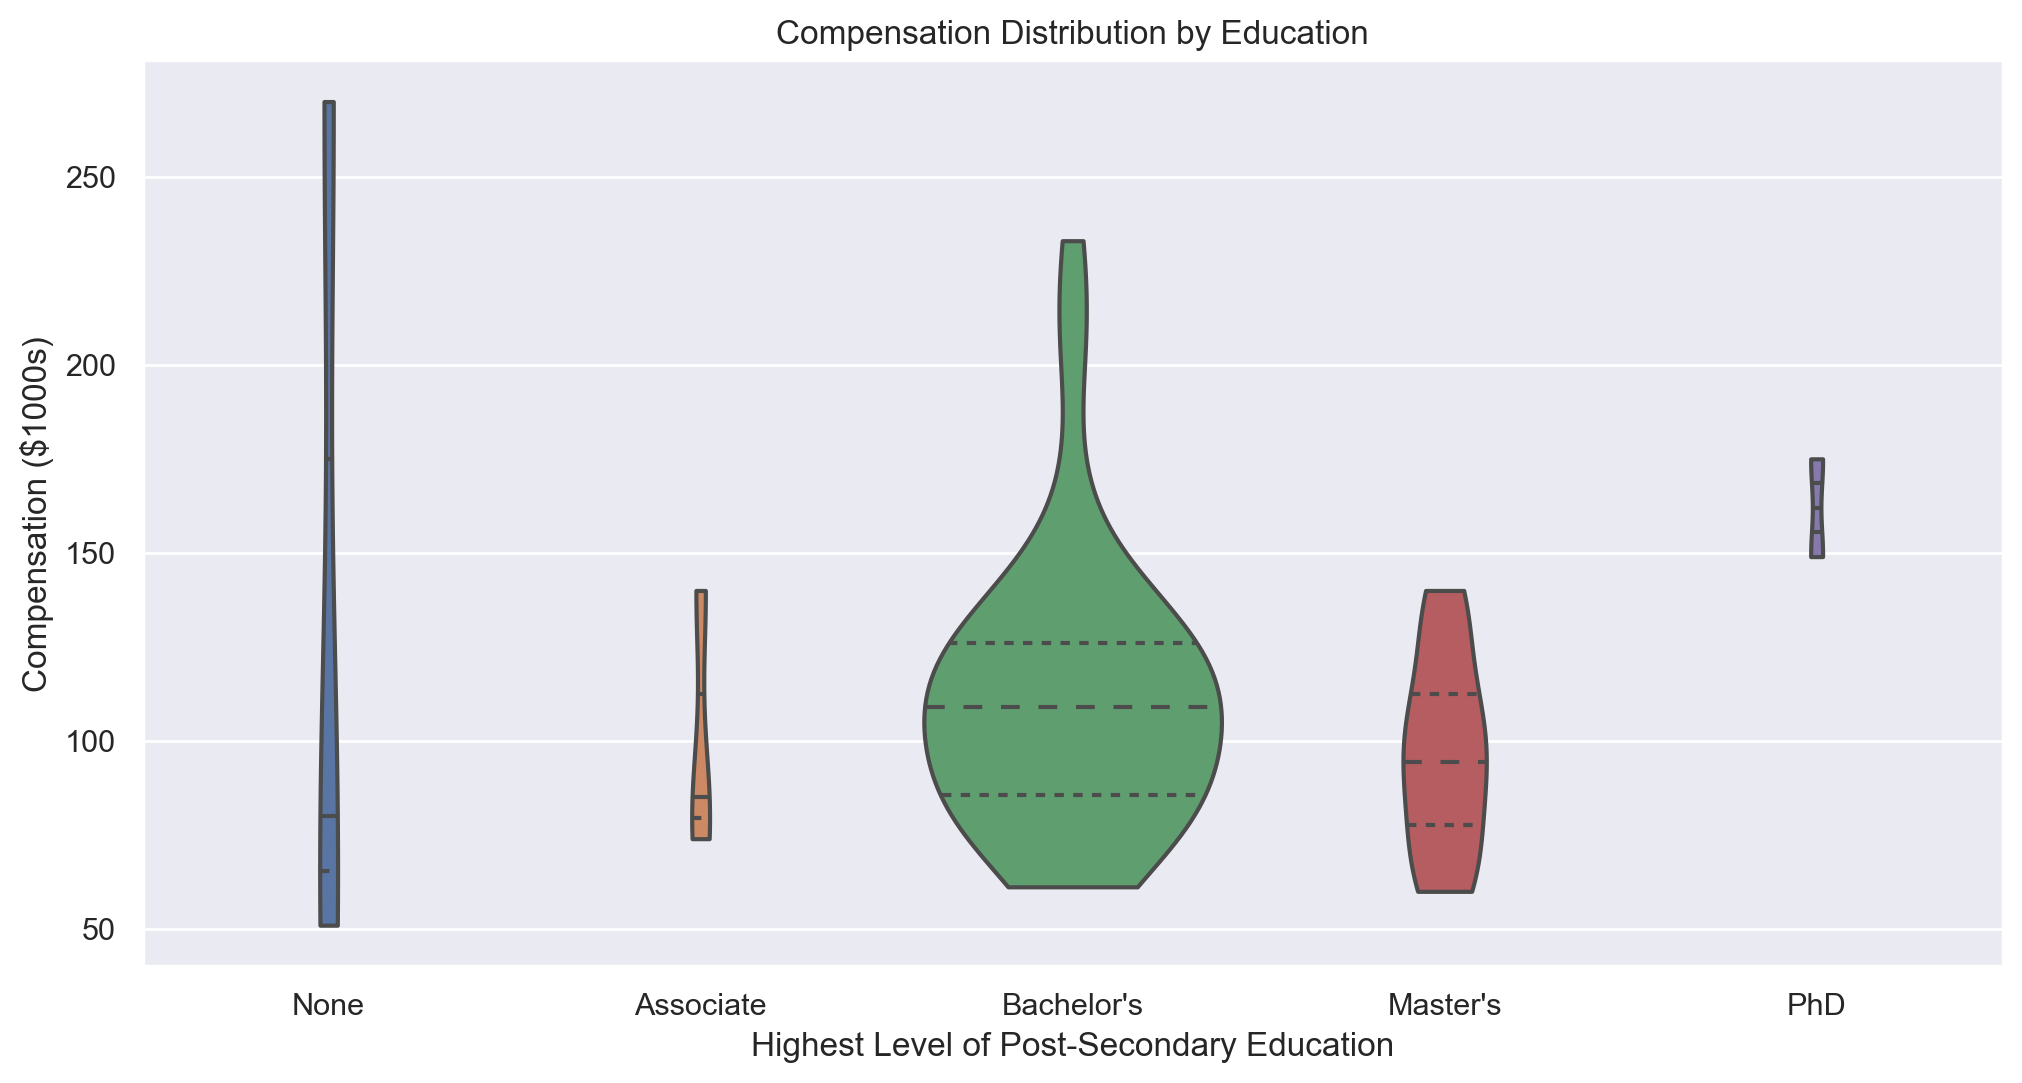

In [89]:
plt.figure(figsize=(10,6), dpi=200)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "education",
    y = "job_income",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    order = ["None", "Associate", "Bachelor's", "Master's", "PhD"], 
    data=data
)
plot.set(
    xlabel="Highest Level of Post-Secondary Education",
    ylabel="Compensation ($1000s)",
    title="Compensation Distribution by Education"
)
plot.get_figure().savefig("figures/by_education.svg")

<Figure size 2000x1200 with 0 Axes>

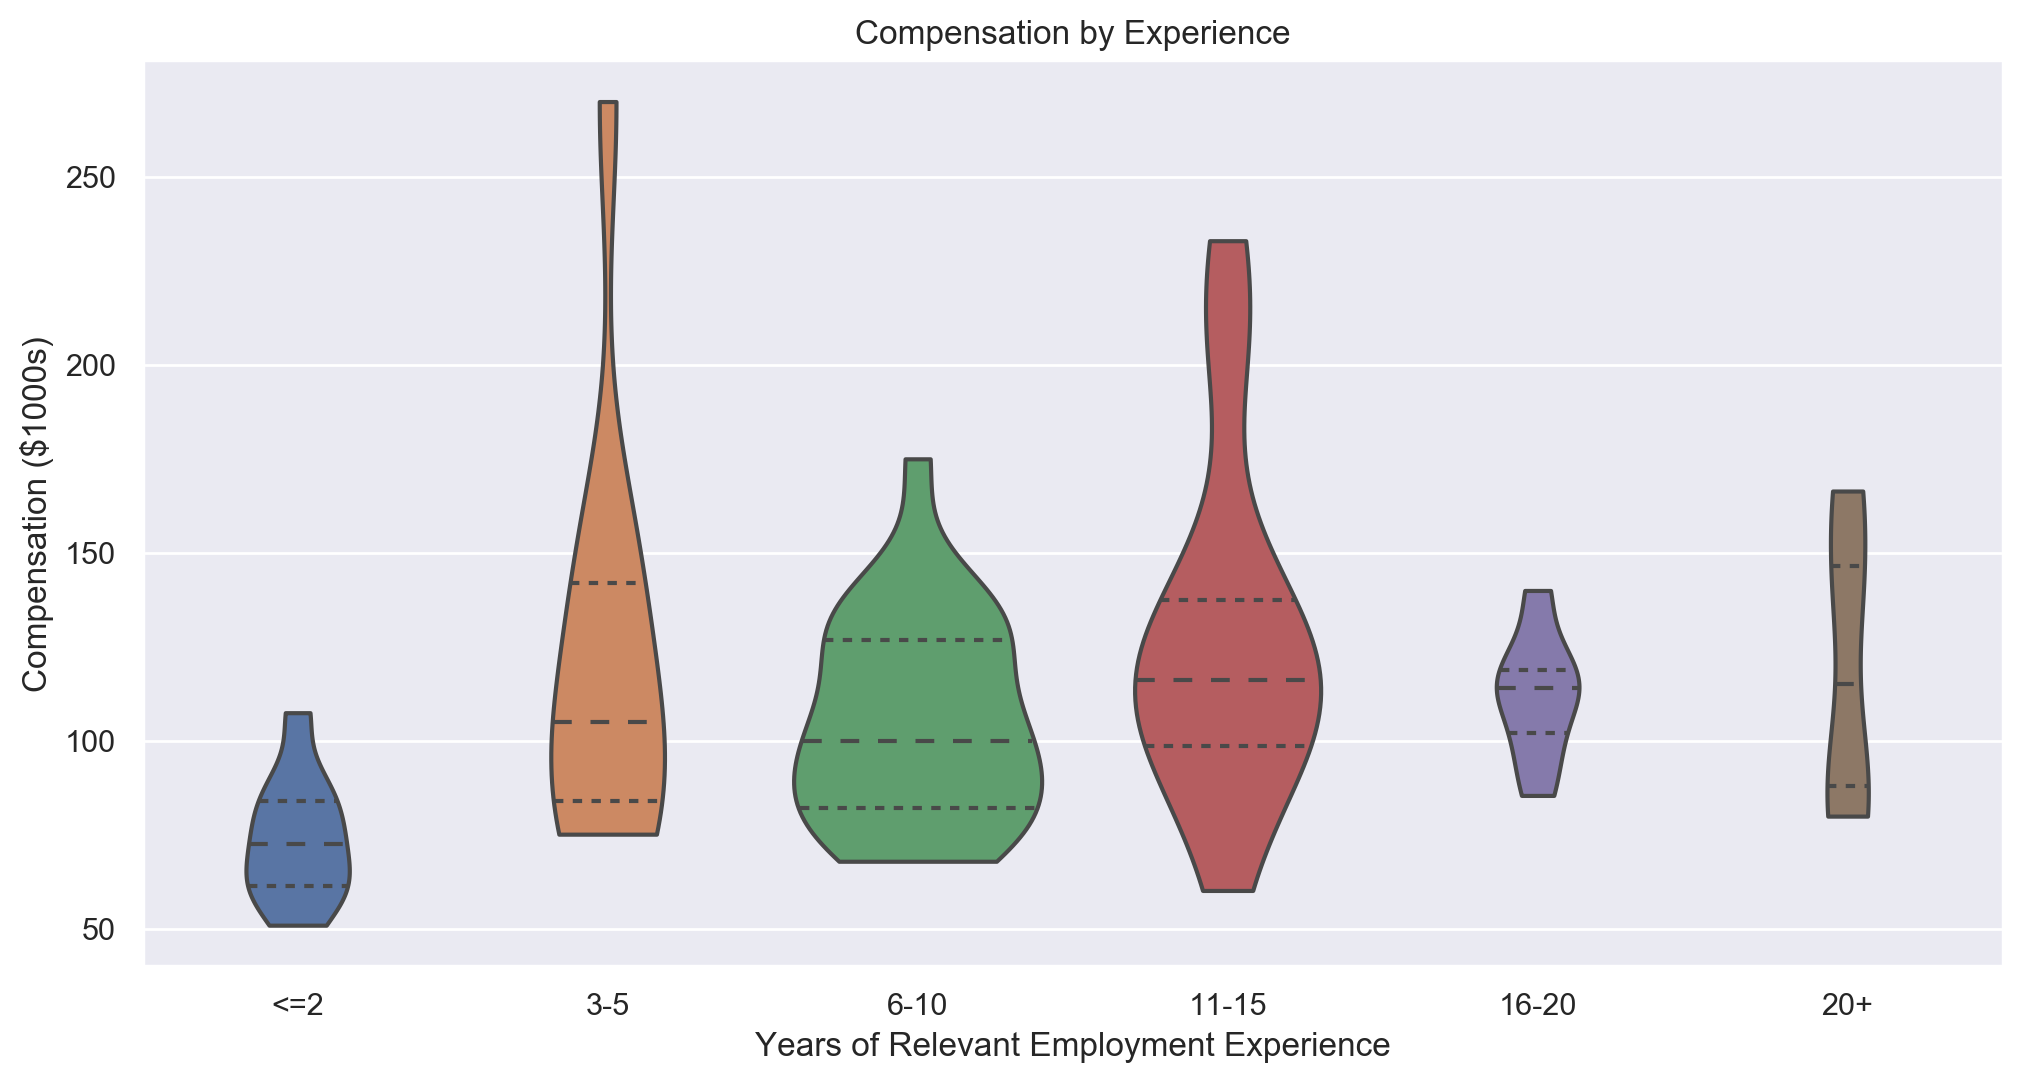

In [90]:
plt.figure(figsize=(10,6), dpi=200)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "experience",
    y = "job_income",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Years of Relevant Employment Experience",
    ylabel="Compensation ($1000s)",
    title="Compensation by Experience"
)
plot.get_figure().savefig("figures/by_experience.svg")
plt.show()

In [91]:
# Total number of respondents
n = data.consent_1.count()

print("There were a total of " + str(n) + " respondents to the survey.")

# Number of respondents reporting outside income
num_oi = data.outside_income[data.outside_income > 0].count()
num_oi = float(num_oi)


print(data['outside_income'].value_counts())

data.count()


There were a total of 82 respondents to the survey.
0.0        9
15000.0    2
20000.0    2
50000.0    1
5000.0     1
9600.0     1
10000.0    1
30000.0    1
Name: outside_income, dtype: int64


consent_1                 82
extra                      9
consent_2                 82
job_title                 66
job_role                  81
benefits_salary           79
benefits_salary_year      71
benefits_paid_vac_days    76
benefits_bonus            82
job_reports               75
job_type                  77
employer_dept             36
employer_ownership        49
employer_fte              64
loc                       73
experience                77
job_remote                79
employer_loc              55
benefits_other            31
gender                    75
education                 74
identity                  39
race                      64
universities              38
job_description           25
job_tenure                75
outside_income            18
job_income                79
dtype: int64

In [92]:
np.mean(data.job_income)

110.51282278481014